## Génération d'un tableau de coordonnées fictives

In [2]:
import numpy as np

atomes_nb = 6
atomes_nb_incl_fictif = atomes_nb + 1


# Génération d'une matrice de positions des atomes d'une molécule. Pour chaque atome, 
# une ligne contient 3 coordonnées x, y, z, chacune dans l'intervalle [-1,1[. 
def gen_pos(nb_atomes):
    return (np.random.random_sample(atomes_nb*3) * 2 - 1).reshape(-1,3)

positions = gen_pos(atomes_nb)
positions

array([[-0.01021869,  0.4321829 , -0.08206913],
       [-0.18246734, -0.08164166,  0.77005448],
       [-0.05753804,  0.48558706, -0.24695021],
       [ 0.3687509 , -0.2593858 , -0.04567559],
       [ 0.38624583, -0.23255142,  0.46361445],
       [-0.04122078, -0.48911327, -0.14040329]])

## Conversion des coordonnées en distances

L'objectif est de fournir au réseau de neurones un vecteur contenant chaque coordonnée x, y, z et masse m des atomes contenant la molécule, afin d'obtenir en sortie le déplacement nécessaire des atomes et d'en déduire les nouvelles positions. On ne s'intéresse ici qu'aux positions, afin d'obtenir la matrice distances de la molécule.

La matrice distances contient pour chaque atome la distance aux 4 atomes suivants (dans l'ordre donné au vecteur positions initial). Si l'atome suivant n'existe pas (on arrive à la fin de la liste), alors on impute une valeur 0.

Afin de s'assurer que l'on pourra reconstruire la molécule avec la différence de distances fournie en sortie du RN, on ajoute un atome fictif prenant comme indice 0 et qui possédera une masse nulle. Cet atome peut être placé librement, à condition qu'il n'appartienne pas au plan formé par les trois premiers atomes.

### Ajout d'un atome fictif

In [3]:
def ajout_atome_fictif(positions):
    """ Ajoute un atome fictif aux positions initiales. Pour le moment, le place simplement
    aux coordonnées (0,0,0.5). Dans le futur, elle le placera à une position n'appartenant pas avec
    certitude au plan formé par les trois premiers atomes. """
    return np.insert(positions, 0, [0,0,.5], axis=0).reshape(-1,3)
    
positions = ajout_atome_fictif(positions)
positions

array([[ 0.        ,  0.        ,  0.5       ],
       [-0.01021869,  0.4321829 , -0.08206913],
       [-0.18246734, -0.08164166,  0.77005448],
       [-0.05753804,  0.48558706, -0.24695021],
       [ 0.3687509 , -0.2593858 , -0.04567559],
       [ 0.38624583, -0.23255142,  0.46361445],
       [-0.04122078, -0.48911327, -0.14040329]])

### Génération du vecteur distances

In [4]:
import math


def get_atome_coord(positions, index):
    """ Renvoie les coordonnées de l'atome ayant l'index donné """
    return (positions[index])
    
def calcul_dist(x1, y1, z1, x2, y2, z2):
    """ Calcule et retourne la distance entre deux points selon leurs coordonnées en 3 dimensions"""

    return math.sqrt(pow(x1 - x2, 2) + pow(y1 - y2, 2) + pow(z1 - z2, 2))
    
def get_val_dist_matrice(i, j, positions):
    """ Renvoie la valeur de la matrice de distances aux coordonnées (i, j). La matrice complète n'est
    jamais calculée. """
    coord_i = get_atome_coord(positions, i)  # Coordonnées de l'atome i
    coord_j = get_atome_coord(positions, j)  # Coordonnées de l'atome j

    return calcul_dist(coord_i[0], coord_i[1], coord_i[2], coord_j[0], coord_j[1], coord_j[2])
    
def matrice_distances_compr(positions, nb_atomes):
    """ Renvoie le vecteur de distances à partir des coordonnées des atomes et du nombre d'atomes dans
    la molécule. La matrice de distances complète n'est pas générée, seules les valeurs nécessaires
    sont calculées à la demande """
    mat_distances = np.zeros(shape=(nb_atomes-1,4))
    
    for j in range(nb_atomes - 1):
        k=0  # Permet d'accéder simplement à l'indice dans le tableau de sortie
        for i in range(j+1, j+5):
            if i < nb_atomes:
                mat_distances[j][k] = get_val_dist_matrice(i, j, positions)
            k += 1
            
    return mat_distances

distances = matrice_distances_compr(positions, atomes_nb_incl_fictif)
distances

array([[0.72504548, 0.33598975, 0.89277099, 0.70782771],
       [1.00985144, 0.17965772, 0.78943632, 0.94700918],
       [1.17117646, 1.00042495, 0.66341082, 1.00743092],
       [0.88159985, 1.10343515, 0.98064225, 0.        ],
       [0.51029648, 0.47940049, 0.        , 0.        ],
       [0.78319161, 0.        , 0.        , 0.        ]])

### Test de la génération du vecteur distances

In [5]:
# On génère un tableau de positions d'atomes
pos_test = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]).reshape(-1,3)
nb_atomes_test = int(len(pos_test))

# On ajoute l'atome fictif
pos_test = ajout_atome_fictif(pos_test)

# Valeurs attendues du vecteur distances
# [d10, d20, d30, d40,
#  d21, d31, d41, d51,
#  d32, d42, d52, 0,
#  d43, d53, 0,   0,
#  d54, 0,   0,   0]
#
# d10 = 3,74...
# d20 = 8,77...
# d30 = 13,92...
# d40 = 19,10...
# d21 = 5,19...
# d31 = 10,39...
# d41 = 15,58...
# d51 = 20,78...
# d32 = 5,19...
# d42 = 10,39...
# d52 = 15,58...
# d43 = 5,19...
# d53 = 10,39...
# d54 = 5,19...

distances_test = matrice_distances_compr(pos_test, nb_atomes_test)

# Les valeurs de retour sont bien celles attendues

distances_test

array([[ 3.74165739,  8.77496439, 13.92838828, 19.10497317],
       [ 5.19615242, 10.39230485, 15.58845727,  0.        ],
       [ 5.19615242, 10.39230485,  0.        ,  0.        ],
       [ 5.19615242,  0.        ,  0.        ,  0.        ]])

## Déduction des positions en fonction des distances

La sortie du RN nous fournit un vecteur différence de distance (que l'on note delta_distances) qui correspond aux variations des distances inter-atomiques de la molécule induites par l'optimisation. La connaissance du vecteur distances fourni en entrée du RN permet de déduire le nouveau vecteur distance, et la connaissance des coordonnées de l'atome fictif permet de déduire les nouvelles positions des atomes de la molécule.

### Calcul des nouvelles distances inter-atomiques

#### Simulation de la sortie du RN

In [6]:
def simulation_rn_nul(distances_init, atomes_nb):
    """ On simule la sortie d'un RN n'ayant aucune incidence sur les données initiales
    (matrice variation de distances nulle)"""
    return np.zeros(shape=(atomes_nb-1,4))

# On simule l'appel au RN pour obtenir le vecteur variations de distances
delta_distances = simulation_rn_nul(distances_test, atomes_nb_incl_fictif)

def simulation_rn_bruit(distances_init, atomes_nb, sigma):
    """ On simule la sortie d'un RN ajoutant une légère variation de distances"""
    return np.random.normal(0, sigma, 4*(atomes_nb-1)).reshape(atomes_nb-1, 4)

delta_distances_bruit = simulation_rn_bruit(distances, atomes_nb_incl_fictif, 0.01)

delta_distances_bruit

array([[ 0.0165687 , -0.01587458, -0.00607199,  0.00561653],
       [-0.01625693,  0.00690608, -0.00421905,  0.00523158],
       [-0.01065689, -0.01408589, -0.0065528 , -0.01590901],
       [ 0.00428703,  0.00372169, -0.01652154,  0.00717787],
       [-0.00529164,  0.00257222,  0.00444491,  0.00582569],
       [-0.00392897, -0.00115905,  0.00687482, -0.01513024]])

## Tentatives de résolution du problème de la localisation d'un point

Afin de déterminer les coordonnées d'un point de l'espace en fonction de sa distance relative avec quatre autres points dont les positions sont connues, on tente ici d'appliquer plusieurs méthodes différentes.

### Résolution générale du système général (décrivant les quatre sphères)

On peut dans un premier temps tenter de résoudre le système d'équation exprimant les coordonnées du point recherché en fonction de sa distance avec les autres points de manière générale. Si cette méthode fonctionne, alors on pourra calculer directement les coordonnées xn, yn et zn (n>=4) de chaque point, sans faire appel à un solveur à chaque résolution, et donc en évitant la nécessité de résoudre une instance du système à chaque placement de point.

Le problème de cette méthode (voir plus bas) est qu'elle nécessite le calcul d'équation très complexes, et que le solveur utilisé (sympy) n'arrive pas à trouver de solution.

#### Expression de xn en fonction de yn, zn et des autres paramètres

In [7]:
from sympy import Symbol
from sympy.solvers.solveset import *

# Tentative résolution système général

# Variables recherchées
xn = Symbol('xn')
yn = Symbol('yn')
zn = Symbol('zn')

# Position du point (n-4)
xnm4 = Symbol('xnm4')
ynm4 = Symbol('ynm4')
znm4 = Symbol('znm4')

# Position du point (n-3)
xnm3 = Symbol('xnm3')
ynm3 = Symbol('ynm3')
znm3 = Symbol('znm3')

# Position du point (n-2)
xnm2 = Symbol('xnm2')
ynm2 = Symbol('ynm2')
znm2 = Symbol('znm2')

# Position du point (n-1)
xnm1 = Symbol('xnm1')
ynm1 = Symbol('ynm1')
znm1= Symbol('znm1')

# Distances entre le point n recherché et les points (n-4), (n-3), (n-2) et (n-1)
dn_nm4 = Symbol('dn_nm4')
dn_nm3 = Symbol('dn_nm3')
dn_nm2 = Symbol('dn_nm2')
dn_nm1 = Symbol('dn_nm1')

# Formalisation du système
eqs = []
eqs.append((xn - xnm4)**2 + (yn - ynm4)**2
           + (zn - znm4)**2 - dn_nm4**2)

eqs.append((xn - xnm3)**2 + (yn - ynm3)**2
           + (zn - znm3)**2 - dn_nm3**2)

eqs.append((xn - xnm2)**2 + (yn - ynm2)**2
           + (zn - znm2)**2 - dn_nm2**2)

eqs.append((xn - xnm1)**2 + (yn - ynm1)**2
           + (zn - znm1)**2 - dn_nm1**2)

# Expression de xn en fonction des autres variables et paramètres
nonlinsolve(eqs, [xn])

{(xnm1 - sqrt(dn_nm1**2 - yn**2 + 2*yn*ynm1 - ynm1**2 - zn**2 + 2*zn*znm1 - znm1**2),), (xnm1 + sqrt(dn_nm1**2 - yn**2 + 2*yn*ynm1 - ynm1**2 - zn**2 + 2*zn*znm1 - znm1**2),)}

#### Expression de yn en fonction de zn et des autres paramètres

On remplace ici les xn par la solution trouvée plus haut et on recherche yn exprimé en fonction de zn et des paramètres de position des autres points et de distance.

On remarque que l'on obtient deux solutions très complexes

In [7]:

eqs = []
eqs.append((xnm1 + sqrt(dn_nm1**2 - yn**2 + 2*yn*ynm1 - ynm1**2 - zn**2 + 2*zn*znm1 - znm1**2) - xnm4)**2 + (yn - ynm4)**2
           + (zn - znm4)**2 - dn_nm4**2)

eqs.append((xnm1 + sqrt(dn_nm1**2 - yn**2 + 2*yn*ynm1 - ynm1**2 - zn**2 + 2*zn*znm1 - znm1**2) - xnm3)**2 + (yn - ynm3)**2
           + (zn - znm3)**2 - dn_nm3**2)

eqs.append((xnm1 + sqrt(dn_nm1**2 - yn**2 + 2*yn*ynm1 - ynm1**2 - zn**2 + 2*zn*znm1 - znm1**2) - xnm2)**2 + (yn - ynm2)**2
           + (zn - znm2)**2 - dn_nm2**2)

eqs.append((xnm1 + sqrt(dn_nm1**2 - yn**2 + 2*yn*ynm1 - ynm1**2 - zn**2 + 2*zn*znm1 - znm1**2) - xnm1)**2 + (yn - ynm1)**2
           + (zn - znm1)**2 - dn_nm1**2)
nonlinsolve(eqs, [yn])

NameError: name 'sqrt' is not defined

#### Expression de zn en fonction des paramètres

On cherche ici à exprimer zn en fonction des positions des autres points et des distances relatives entre le point n et les autres points, dans le but de remplacer zn par cette expression dans les équations précédentes, afin d'exprimer finalement xn, yn en fonction de ces paramètres.

Malheureusement, le solveur ne trouve pas de solution. On abandonne donc la solution de vouloir exprimer chaque variable du système à 4 équations en fonction des paramètres.

In [39]:
eqs = []

eqs.append(-(xnm1 - xnm2)*sqrt(-dn_nm1**4 + 2*dn_nm1**2*dn_nm2**2 
                               + 2*dn_nm1**2*xnm1**2 - 4*dn_nm1**2*xnm1*xnm2 + 2*dn_nm1**2*xnm2**2 
                               + 2*dn_nm1**2*ynm1**2 - 4*dn_nm1**2*ynm1*ynm2 + 2*dn_nm1**2*ynm2**2 
                               - 4*dn_nm1**2*zn*znm1 + 4*dn_nm1**2*zn*znm2 + 2*dn_nm1**2*znm1**2 
                               - 2*dn_nm1**2*znm2**2 - dn_nm2**4 + 2*dn_nm2**2*xnm1**2 
                               - 4*dn_nm2**2*xnm1*xnm2 + 2*dn_nm2**2*xnm2**2 + 2*dn_nm2**2*ynm1**2 
                               - 4*dn_nm2**2*ynm1*ynm2 + 2*dn_nm2**2*ynm2**2 + 4*dn_nm2**2*zn*znm1 
                               - 4*dn_nm2**2*zn*znm2 - 2*dn_nm2**2*znm1**2 + 2*dn_nm2**2*znm2**2 
                               - xnm1**4 + 4*xnm1**3*xnm2 - 6*xnm1**2*xnm2**2 - 2*xnm1**2*ynm1**2 
                               + 4*xnm1**2*ynm1*ynm2 - 2*xnm1**2*ynm2**2 - 4*xnm1**2*zn**2 
                               + 4*xnm1**2*zn*znm1 + 4*xnm1**2*zn*znm2 - 2*xnm1**2*znm1**2 
                               - 2*xnm1**2*znm2**2 + 4*xnm1*xnm2**3 + 4*xnm1*xnm2*ynm1**2 
                               - 8*xnm1*xnm2*ynm1*ynm2 + 4*xnm1*xnm2*ynm2**2 + 8*xnm1*xnm2*zn**2 
                               - 8*xnm1*xnm2*zn*znm1 - 8*xnm1*xnm2*zn*znm2 + 4*xnm1*xnm2*znm1**2 
                               + 4*xnm1*xnm2*znm2**2 - xnm2**4 - 2*xnm2**2*ynm1**2 + 4*xnm2**2*ynm1*ynm2 
                               - 2*xnm2**2*ynm2**2 - 4*xnm2**2*zn**2 + 4*xnm2**2*zn*znm1 
                               + 4*xnm2**2*zn*znm2 - 2*xnm2**2*znm1**2 - 2*xnm2**2*znm2**2 
                               - ynm1**4 + 4*ynm1**3*ynm2 - 6*ynm1**2*ynm2**2 - 4*ynm1**2*zn**2 
                               + 4*ynm1**2*zn*znm1 + 4*ynm1**2*zn*znm2 - 2*ynm1**2*znm1**2 
                               - 2*ynm1**2*znm2**2 + 4*ynm1*ynm2**3 + 8*ynm1*ynm2*zn**2 
                               - 8*ynm1*ynm2*zn*znm1 - 8*ynm1*ynm2*zn*znm2 + 4*ynm1*ynm2*znm1**2 
                               + 4*ynm1*ynm2*znm2**2 - ynm2**4 - 4*ynm2**2*zn**2 + 4*ynm2**2*zn*znm1 
                               + 4*ynm2**2*zn*znm2 - 2*ynm2**2*znm1**2 - 2*ynm2**2*znm2**2 
                               - 4*zn**2*znm1**2 + 8*zn**2*znm1*znm2 - 4*zn**2*znm2**2 + 4*zn*znm1**3 
                               - 4*zn*znm1**2*znm2 - 4*zn*znm1*znm2**2 + 4*zn*znm2**3 - znm1**4 
                               + 2*znm1**2*znm2**2 - znm2**4)/(2*(xnm1**2 - 2*xnm1*xnm2 + xnm2**2 + ynm1**2 
                               - 2*ynm1*ynm2 + ynm2**2)) - (dn_nm1**2*ynm1 - dn_nm1**2*ynm2 - dn_nm2**2*ynm1 
                               + dn_nm2**2*ynm2 - xnm1**2*ynm1 - xnm1**2*ynm2 + 2*xnm1*xnm2*ynm1 + 2*xnm1*xnm2*ynm2 
                               - xnm2**2*ynm1 - xnm2**2*ynm2 - ynm1**3 + ynm1**2*ynm2 + ynm1*ynm2**2 
                               + 2*ynm1*zn*znm1 - 2*ynm1*zn*znm2 - ynm1*znm1**2 + ynm1*znm2**2 - ynm2**3 
                               - 2*ynm2*zn*znm1 + 2*ynm2*zn*znm2 + ynm2*znm1**2 - ynm2*znm2**2)/(2*(xnm1**2 
                               - 2*xnm1*xnm2 + xnm2**2 + ynm1**2 - 2*ynm1*ynm2 + ynm2**2)))

nonlinsolve(eqs, [zn])



{(ConditionSet(zn, Eq(-dn_nm1**2*ynm1 + dn_nm1**2*ynm2 + dn_nm2**2*ynm1 - dn_nm2**2*ynm2 + xnm1**2*ynm1 + xnm1**2*ynm2 - 2*xnm1*xnm2*ynm1 - 2*xnm1*xnm2*ynm2 + xnm2**2*ynm1 + xnm2**2*ynm2 + ynm1**3 - ynm1**2*ynm2 - ynm1*ynm2**2 - 2*ynm1*zn*znm1 + 2*ynm1*zn*znm2 + ynm1*znm1**2 - ynm1*znm2**2 + ynm2**3 + 2*ynm2*zn*znm1 - 2*ynm2*zn*znm2 - ynm2*znm1**2 + ynm2*znm2**2 + (-xnm1 + xnm2)*sqrt(-dn_nm1**4 + 2*dn_nm1**2*dn_nm2**2 + 2*dn_nm1**2*xnm1**2 - 4*dn_nm1**2*xnm1*xnm2 + 2*dn_nm1**2*xnm2**2 + 2*dn_nm1**2*ynm1**2 - 4*dn_nm1**2*ynm1*ynm2 + 2*dn_nm1**2*ynm2**2 - 4*dn_nm1**2*zn*znm1 + 4*dn_nm1**2*zn*znm2 + 2*dn_nm1**2*znm1**2 - 2*dn_nm1**2*znm2**2 - dn_nm2**4 + 2*dn_nm2**2*xnm1**2 - 4*dn_nm2**2*xnm1*xnm2 + 2*dn_nm2**2*xnm2**2 + 2*dn_nm2**2*ynm1**2 - 4*dn_nm2**2*ynm1*ynm2 + 2*dn_nm2**2*ynm2**2 + 4*dn_nm2**2*zn*znm1 - 4*dn_nm2**2*zn*znm2 - 2*dn_nm2**2*znm1**2 + 2*dn_nm2**2*znm2**2 - xnm1**4 + 4*xnm1**3*xnm2 - 6*xnm1**2*xnm2**2 - 2*xnm1**2*ynm1**2 + 4*xnm1**2*ynm1*ynm2 - 2*xnm1**2*ynm2**2 - 4*xnm1*

### Résolution générale du système partiel (contenant la description de trois sphères)

On cherche toujours ici à résoudre le système d'équations de façon générale, afin d'éviter d'utiliser un solveur à chaque recherche des coordonnées d'un point. La différence avec la méthode développée ci-dessus est qu'on ne va pas chercher à trouver l'intersection de quatre sphères mais de seulement trois. L'idée est que dans le cas où les quatre premiers points ne sont pas alignés, l'intersection de trois sphères ayant pour centres trois des points et pour rayon la distance entre ces points et le point recherché possèdera deux solutions. Une seule de ces solutions correspond au point recherché, mais nous pourrons déterminer ce point en fonction de la distance avec le point que l'on aura ignoré jusque là.

Formellement, nous allons tenter de trouver la solution générale de l'intersection entre les sphères de centres respectifs a(n-4), a(n-3) et a(n-2) et de rayons respectifs dn_nm4, dn_nm3, dn_nm2. L'ensemble de solution devrait contenir deux valeurs, parmi lesquelles on sélectionnera au cas par cas (à chaque recherche) celle dont la distance avec le point a(n-1) sera la plus proche de la valeur de dn_nm1.

On réalise que les équations sont encore trop complexes, on va donc tenter une nouvelle approche

#### Expression de xn en fonction de yn, zn et des paramètres


In [ ]:
# Formalisation du système
eqs = []

xn = Symbol("xn")

eqs.append((xn - xnm4)**2 + (yn - ynm4)**2
           + (zn - znm4)**2 - dn_nm4**2)

eqs.append((xn - xnm3)**2 + (yn - ynm3)**2
           + (zn - znm3)**2 - dn_nm3**2)

eqs.append((xn - xnm2)**2 + (yn - ynm2)**2
           + (zn - znm2)**2 - dn_nm2**2)

nonlinsolve(eqs, [xn, yn, zn])


In [7]:
# Formalisation du système
eqs = []

xn = Symbol("xn")

eqs.append((xn - xnm4)**2 + (yn - ynm4)**2
           + (zn - znm4)**2 - dn_nm4**2)

# Expression de xn en fonction des autres variables et paramètres
nonlinsolve(eqs, [xn])

{(xnm4 - sqrt(dn_nm4**2 - yn**2 + 2*yn*ynm4 - ynm4**2 - zn**2 + 2*zn*znm4 - znm4**2),), (xnm4 + sqrt(dn_nm4**2 - yn**2 + 2*yn*ynm4 - ynm4**2 - zn**2 + 2*zn*znm4 - znm4**2),)}

#### Expression de yn en fonction de zn et des paramètres pour chaque solution de xn

On remplace xn par l'expression calculée au dessus et on en déduit l'expression de yn en fonction de zn et des paramètres.

In [36]:
from sympy import sqrt
from sympy import solve
# Formalisation du système
eqs = []


eqs.append(((xnm4 + sqrt(dn_nm4**2 - yn**2 + 2*yn*ynm4 - ynm4**2 - zn**2 + 2*zn*znm4 - znm4**2))
 - xnm3)**2 + (yn - ynm3)**2
           + (zn - znm3)**2 - dn_nm3**2)

eqs.append(((xnm4 + sqrt(dn_nm4**2 - yn**2 + 2*yn*ynm4 - ynm4**2 - zn**2 + 2*zn*znm4 - znm4**2))
 - xnm2)**2 + (yn - ynm2)**2
           + (zn - znm2)**2 - dn_nm2**2)
# Expression de yn en fonction de zn et des paramètres

nonlinsolve(eqs, [yn])

{(-(xnm2 - xnm4)*sqrt(-dn_nm2**4 + 2*dn_nm2**2*dn_nm4**2 + 2*dn_nm2**2*xnm2**2 - 4*dn_nm2**2*xnm2*xnm4 + 2*dn_nm2**2*xnm4**2 + 2*dn_nm2**2*ynm2**2 - 4*dn_nm2**2*ynm2*ynm4 + 2*dn_nm2**2*ynm4**2 - 4*dn_nm2**2*zn*znm2 + 4*dn_nm2**2*zn*znm4 + 2*dn_nm2**2*znm2**2 - 2*dn_nm2**2*znm4**2 - dn_nm4**4 + 2*dn_nm4**2*xnm2**2 - 4*dn_nm4**2*xnm2*xnm4 + 2*dn_nm4**2*xnm4**2 + 2*dn_nm4**2*ynm2**2 - 4*dn_nm4**2*ynm2*ynm4 + 2*dn_nm4**2*ynm4**2 + 4*dn_nm4**2*zn*znm2 - 4*dn_nm4**2*zn*znm4 - 2*dn_nm4**2*znm2**2 + 2*dn_nm4**2*znm4**2 - xnm2**4 + 4*xnm2**3*xnm4 - 6*xnm2**2*xnm4**2 - 2*xnm2**2*ynm2**2 + 4*xnm2**2*ynm2*ynm4 - 2*xnm2**2*ynm4**2 - 4*xnm2**2*zn**2 + 4*xnm2**2*zn*znm2 + 4*xnm2**2*zn*znm4 - 2*xnm2**2*znm2**2 - 2*xnm2**2*znm4**2 + 4*xnm2*xnm4**3 + 4*xnm2*xnm4*ynm2**2 - 8*xnm2*xnm4*ynm2*ynm4 + 4*xnm2*xnm4*ynm4**2 + 8*xnm2*xnm4*zn**2 - 8*xnm2*xnm4*zn*znm2 - 8*xnm2*xnm4*zn*znm4 + 4*xnm2*xnm4*znm2**2 + 4*xnm2*xnm4*znm4**2 - xnm4**4 - 2*xnm4**2*ynm2**2 + 4*xnm4**2*ynm2*ynm4 - 2*xnm4**2*ynm4**2 - 4*xnm4**2

#### Expression de zn en fonction des paramètres 

In [ ]:
eqs = []


yn = ((xnm2 - xnm4)*sqrt(-dn_nm2**4 + 2*dn_nm2**2*dn_nm4**2 + 2*dn_nm2**2*xnm2**2 - 4*dn_nm2**2*xnm2*xnm4 
                    + 2*dn_nm2**2*xnm4**2 + 2*dn_nm2**2*ynm2**2 - 4*dn_nm2**2*ynm2*ynm4 + 2*dn_nm2**2*ynm4**2 
                    - 4*dn_nm2**2*zn*znm2 + 4*dn_nm2**2*zn*znm4 + 2*dn_nm2**2*znm2**2 - 2*dn_nm2**2*znm4**2 
                    - dn_nm4**4 + 2*dn_nm4**2*xnm2**2 - 4*dn_nm4**2*xnm2*xnm4 + 2*dn_nm4**2*xnm4**2 
                    + 2*dn_nm4**2*ynm2**2 - 4*dn_nm4**2*ynm2*ynm4 + 2*dn_nm4**2*ynm4**2 + 4*dn_nm4**2*zn*znm2 
                    - 4*dn_nm4**2*zn*znm4 - 2*dn_nm4**2*znm2**2 + 2*dn_nm4**2*znm4**2 - xnm2**4 
                    + 4*xnm2**3*xnm4 - 6*xnm2**2*xnm4**2 - 2*xnm2**2*ynm2**2 + 4*xnm2**2*ynm2*ynm4 
                    - 2*xnm2**2*ynm4**2 - 4*xnm2**2*zn**2 + 4*xnm2**2*zn*znm2 + 4*xnm2**2*zn*znm4 
                    - 2*xnm2**2*znm2**2 - 2*xnm2**2*znm4**2 + 4*xnm2*xnm4**3 + 4*xnm2*xnm4*ynm2**2 
                    - 8*xnm2*xnm4*ynm2*ynm4 + 4*xnm2*xnm4*ynm4**2 + 8*xnm2*xnm4*zn**2 - 8*xnm2*xnm4*zn*znm2 
                    - 8*xnm2*xnm4*zn*znm4 + 4*xnm2*xnm4*znm2**2 + 4*xnm2*xnm4*znm4**2 - xnm4**4 
                    - 2*xnm4**2*ynm2**2 + 4*xnm4**2*ynm2*ynm4 - 2*xnm4**2*ynm4**2 - 4*xnm4**2*zn**2 
                    + 4*xnm4**2*zn*znm2 + 4*xnm4**2*zn*znm4 - 2*xnm4**2*znm2**2 - 2*xnm4**2*znm4**2 
                    - ynm2**4 + 4*ynm2**3*ynm4 - 6*ynm2**2*ynm4**2 - 4*ynm2**2*zn**2 + 4*ynm2**2*zn*znm2 
                    + 4*ynm2**2*zn*znm4 - 2*ynm2**2*znm2**2 - 2*ynm2**2*znm4**2 + 4*ynm2*ynm4**3 
                    + 8*ynm2*ynm4*zn**2 - 8*ynm2*ynm4*zn*znm2 - 8*ynm2*ynm4*zn*znm4 + 4*ynm2*ynm4*znm2**2 
                    + 4*ynm2*ynm4*znm4**2 - ynm4**4 - 4*ynm4**2*zn**2 + 4*ynm4**2*zn*znm2 
                    + 4*ynm4**2*zn*znm4 - 2*ynm4**2*znm2**2 - 2*ynm4**2*znm4**2 - 4*zn**2*znm2**2 
                    + 8*zn**2*znm2*znm4 - 4*zn**2*znm4**2 + 4*zn*znm2**3 - 4*zn*znm2**2*znm4 
                    - 4*zn*znm2*znm4**2 + 4*zn*znm4**3 - znm2**4 + 2*znm2**2*znm4**2 - znm4**4)
                    /(2*(xnm2**2 - 2*xnm2*xnm4 + xnm4**2 + ynm2**2 - 2*ynm2*ynm4 + ynm4**2)) 
                    - (dn_nm2**2*ynm2 - dn_nm2**2*ynm4 - dn_nm4**2*ynm2 + dn_nm4**2*ynm4 - xnm2**2*ynm2 
                    - xnm2**2*ynm4 + 2*xnm2*xnm4*ynm2 + 2*xnm2*xnm4*ynm4 - xnm4**2*ynm2 - xnm4**2*ynm4 
                    - ynm2**3 + ynm2**2*ynm4 + ynm2*ynm4**2 + 2*ynm2*zn*znm2 - 2*ynm2*zn*znm4 
                    - ynm2*znm2**2 + ynm2*znm4**2 - ynm4**3 - 2*ynm4*zn*znm2 + 2*ynm4*zn*znm4 
                    + ynm4*znm2**2 - ynm4*znm4**2)/(2*(xnm2**2 - 2*xnm2*xnm4 + xnm4**2 + ynm2**2 
                    - 2*ynm2*ynm4 + ynm4**2)))

xn = (xnm4 + sqrt(dn_nm4**2 - yn**2 + 2*yn*ynm4 - ynm4**2 - zn**2 + 2*zn*znm4 - znm4**2))


eqs.append((xn - xnm4)**2 + (yn - ynm4)**2
           + (zn - znm4)**2 - dn_nm4**2)

eqs.append((xn - xnm3)**2 + (yn - ynm3)**2
           + (zn - znm3)**2 - dn_nm3**2)


nonlinsolve(eqs, [zn])



### Utilisation d'un solveur pour résoudre le système composé de trois équations (méthode retenue)

In [16]:

from sympy import Symbol
from sympy.solvers import solve
from sympy import Add
from sympy import sqrt
from mpmath import *
from sympy.solvers.solveset import nonlinsolve

def calcul_distance(x1, y1, z1, x2, y2, z2):
    
    if isinstance(x1, complex):
        print("x1 complexe")
    
    if isinstance(x2, complex):
        print("x2 complexe")
    
    if isinstance(y1, complex):
        print("y1 complexe")
    
    if isinstance(y2, complex):
        print("y2 complexe")
    
    if isinstance(z1, complex):
        print("z1 complexe")
    
    if isinstance(z2, complex):
        print("z2 complexe")
    
    
    return math.sqrt((x2-x1)**2 + (y2-y1)**2 + (z2-z1)**2)

def get_distance(distances, at1, at2):
    """ Renvoie la distance entre deux atomes selon la matrice de distances compressée """
    
    # On a besoin de l'atome de numéro le plus bas en première position
    if (at1 > at2):
        at1, at2 = at2, at1
        
    if at2 <= at1 or at2 > at1 + 4:
        raise "Cette distance n'est pas connue dans la matrice de distances compressée "
    
    return distances[at1][at2-at1-1]
    
    
def get_valeur_tolerance(seuil, epsilon, valeur):
    """ Renvoie une valeur à laquelle on a ajouté une tolérance epsilon. Si la valeur est comprise entre
    epsilon+seuil et seuil alors on renvoie seuil. Sinon on renvoie la valeur initiale """
    
    if seuil <= valeur <= seuil+epsilon or seuil+epsilon <= valeur <= seuil:
        return seuil
    else:
        return valeur
    

def calcul_positions_a1_a4(distances, pos_at_fictif):
    """ Calcule les positions des atomes a0, a1, a2 et a3 et renvoie une nouvelle matrice de positions
    initialisée à 0 et de taille (nb_atomes, 3) """
    
    nb_atomes = len(distances) + 1
    
    epsilon = -1e-7
    
    positions = np.array(np.zeros(shape=(nb_atomes,3)))
    
    d10 = get_distance(distances, 0, 1)
    d20 = get_distance(distances, 0, 2)
    d21 = get_distance(distances, 1, 2)
    d30 = get_distance(distances, 0, 3)
    d31 = get_distance(distances, 1, 3)
    d32 = get_distance(distances, 2, 3)
        
    # On considère pour le moment que a0 est en (0,0,0)
    positions[0][0] = 0
    positions[0][1] = 0
    positions[0][2] = 0
    
    # Calcul de a1
    positions[1][0] = d10
    positions[1][1] = 0
    positions[1][2] = 0

    # Calcul de a2
    positions[2][0] = (d20**2-d21**2+d10**2)/(2*d10)
    positions[2][1] = math.sqrt(get_valeur_tolerance(0, epsilon, d20**2-((d20**2-d21**2+d10**2)/(2*d10))**2))
    positions[2][2] = 0

    # Calcul de a3
    positions[3][0] = (d30**2+d10**2-d31**2)/(2*d10)
    positions[3][1] = (-2*positions[3][0]*positions[2][0] +d20**2-d32**2+d30**2)/(2*positions[2][1])
    positions[3][2] = math.sqrt(get_valeur_tolerance(0, epsilon,
                                                     -positions[3][0]**2 - positions[3][1]**2 + d30**2))

    # Translation des positions calculées selon le vecteur (Oa0)
    positions[0:4] += pos_at_fictif
    
    return positions   

def points_alignes(pt1, pt2, pt3, epsilon):
    """ Renvoie vrai si les trois points sont alignés et faux sinon, avec une tolérance epsilon.
    On calcule pour cela l'aire du triangle formé par les trois points et on vérifie si elle est inférieure
    à la tolérance epsilon donnée."""
    
    mat1 = np.array(np.zeros(shape=(3,3)))
    mat2 = np.array(np.zeros(shape=(3,3)))
    mat3 = np.array(np.zeros(shape=(3,3)))
    
    mat1[0] = (pt1[0], pt2[0], pt3[0])
    mat1[1] = (pt1[1], pt2[1], pt3[1])
    mat1[2] = (1, 1, 1)
    
    mat2[0] = (pt1[1], pt2[1], pt3[1])
    mat2[1] = (pt1[2], pt2[2], pt3[2])
    mat2[2] = (1, 1, 1)

    mat2[0] = (pt1[2], pt2[2], pt3[2])
    mat2[1] = (pt1[0], pt2[0], pt3[0])
    mat2[2] = (1, 1, 1)
    
    return 0.5*(math.sqrt(np.linalg.det(mat1)**2 + np.linalg.det(mat2)**2 + np.linalg.det(mat3)**2)) < epsilon


    

def calcul_position(positions, distances, id_at): 
    """ Calcul des coordonnées (x, y, z) de l'atome dont l'identifiant est spécifié """
        
    # On récupère les distances entre le point à placer et les quatre points précédents dans la matrice
    # de distances compressée
    dn_nmin4 = get_distance(distances, id_at, id_at-4)
    dn_nmin3 = get_distance(distances, id_at, id_at-3)
    dn_nmin2 = get_distance(distances, id_at, id_at-2)
    dn_nmin1 = get_distance(distances, id_at, id_at-1)
    
    # On utilise un solveur sympy pour calculer les deux points intersection des trois premières sphères
    xn = Symbol('xn')
    yn = Symbol('yn')
    zn = Symbol('zn')
    
    if points_alignes(positions[id_at-4], positions[id_at-3], positions[id_at-2], 0.001):
        print("Les points n-4, n-3 et n-2 sont alignés")
        
    if points_alignes(positions[id_at-3], positions[id_at-2], positions[id_at-1], 0.001):
        print("Les points n-3, n-2 et n-1 sont alignés")
    
    if points_alignes(positions[id_at-4], positions[id_at-2], positions[id_at-1], 0.001):
        print("Les points n-4, n-2 et n-1 sont alignés")
        

    eqs = []
    eqs.append((xn - positions[id_at-4][0])**2 + (yn - positions[id_at-4][1])**2
               + (zn - positions[id_at-4][2])**2 - dn_nmin4**2)
    
    eqs.append((xn - positions[id_at-3][0])**2 + (yn - positions[id_at-3][1])**2
               + (zn - positions[id_at-3][2])**2 - dn_nmin3**2)
    
    eqs.append((xn - positions[id_at-2][0])**2 + (yn - positions[id_at-2][1])**2
               + (zn - positions[id_at-2][2])**2 - dn_nmin2**2)

    
    # On obtient deux solutions, et on retient celle dont la distance avec l'atome (n-1) est la plus proche
    # de la distance prévue dans la matrice de distances compressée
    
    ### TODO : Cas où les quatre premiers atomes sont alignés ### 
    
    #sol = nonlinsolve(eqs, [xn, yn, zn])
    sol = solve(eqs, [xn, yn, zn], check=False)
    
    best_delta_sol = float('inf')
    best_sol = None
    
    for curr_sol in sol:
        
        curr_sol = list(curr_sol)
        delta_sol = abs(calcul_distance(curr_sol[0], curr_sol[1], curr_sol[2],
                                        positions[id_at-1][0], positions[id_at-1][1], positions[id_at-1][2])
                                        - get_distance(distances, id_at, id_at-1))
        if (delta_sol<best_delta_sol):
            best_delta_sol = delta_sol
            best_sol = curr_sol
    
    positions[id_at] = best_sol
    
    return positions
    
def reconstruction_positions(distances_init, delta_distances, pos_at_fictif):
    """ Fonction calculant les nouvelles positions des atomes de la molécule à partir des distances initiales,
    des variations de distances fournies par le RN et de la position initiale de l'atome fictif"""
    
    mp.dps = 40
    
    nb_atomes = len(distances_init)+1
    
    # On commence par calculer la nouvelle matrice compressée de distances
    distances = distances_init + delta_distances
    
    # On calcule les positions des quatre premiers atomes de la molécule (dont l'atome fictif)
    positions = calcul_positions_a1_a4(distances, pos_at_fictif)
    
    # On calcule les positions des atomes restants
    for i in range(4, nb_atomes):
        positions = calcul_position(positions, distances, i)
    
    return positions

#positions_post_traitement = reconstruction_positions(distances_test, delta_distances, pos_test[0])

positions_post_traitement = reconstruction_positions(distances, delta_distances, pos_test[0])

positions_post_traitement




array([[ 0.        ,  0.        ,  0.        ],
       [ 0.45995447,  0.        ,  0.        ],
       [-0.49786398,  0.53302706,  0.        ],
       [ 0.11097179, -0.23299509,  0.66802705],
       [ 1.20315166, -0.1046827 ,  0.43205657],
       [ 0.78379506, -0.72714821, -0.33512688],
       [-0.29341467, -0.38727374,  0.80367687],
       [ 0.70848827,  0.84952443,  0.52373482],
       [-0.62858154,  0.71667788, -0.04270484],
       [-0.36345937,  0.0333165 ,  0.12876934],
       [-0.72471476, -0.65700412,  0.85949838],
       [-0.23914383,  0.71249835,  1.20837166],
       [ 0.44846634,  0.57574884,  0.70040836],
       [ 0.88607178,  1.05579671,  0.53251467],
       [ 0.06420464,  0.89845532, -0.6167618 ],
       [-0.63626063,  0.57846289, -0.1978583 ],
       [ 1.62560498,  0.55873382,  0.74872009],
       [-0.33485707,  0.84723606,  0.38038471],
       [-0.23473507,  0.12196273, -0.95190318],
       [ 0.30725775, -0.20964748,  0.14119615],
       [-0.38971585,  0.79646047,  0.455

### Vérification de la reconstruction de molécule

#### Vérification sur une molécule

Pour vérifier que la reconstruction fonctionne, on prend la molécule en sortie de la reconstruction, on calcule ses nouvelles distances internes et on tente de la reconstruire pour vérifier que l'on obtient bien la même molécule

In [11]:

nouvelles_distances = matrice_distances_compr(positions_post_traitement, atomes_nb_incl_fictif)

positions_post_traitement_verif = reconstruction_positions(nouvelles_distances, delta_distances, pos_test[0])
positions_post_traitement_verif


Les points n-4, n-3 et n-2 sont alignés
Les points n-3, n-2 et n-1 sont alignés
Les points n-4, n-2 et n-1 sont alignés
Les points n-4, n-3 et n-2 sont alignés
Les points n-4, n-2 et n-1 sont alignés


array([[ 0.        ,  0.        ,  0.        ],
       [ 0.72504548,  0.        ,  0.        ],
       [-0.26289376,  0.20922712,  0.        ],
       [ 0.88991251,  0.01476801,  0.06984028],
       [ 0.27825932, -0.5750584 ,  0.30479446],
       [-0.11485179, -0.43737764,  0.00998916],
       [ 0.22314989, -0.31939264,  0.70656902]])

La molécule a bien été reconstruite à l'identique, on vérifie maintenant que les distances internes sont les mêmes (à 10^-8 près).

In [12]:
epsilon = 1e-8
print((abs(distances - nouvelles_distances) < epsilon).all())

True


#### Vérification sur n molécules

On va maintenant appliquer la même méthode de vérification sur n molécules : on génère des positions aléatoirement, on simule un vecteur variation de distances nul et on reconstruit la molécule. On vérifie ensuite que les coordonnées des deux molécules sont identiques à 10-8 près 

In [19]:

def check_n_reconstructions(iterations, nb_atomes, epsilon, check_positions=True):
    """ Teste la reconstruction de iterations molécules contenant chacune nb_atomes atomes. La reconstruction
    de chaque molécule est validée si la différence entre les distances attendues et les distances calculées
    après la reconstructions est inférieure à l'epsilon donné.
    Si le paramètre check_positions est vrai, alors on reconstruit la molécule une fois de plus à chaque
    itération et on vérifie que les deux reconstructions ont produit les mêmes positions à epsilon près
    """
    
    succes = True
    
    erreurs_pos = 0
    erreurs_dist = 0
    
    for i in range(n):

        succes_courant = True
        
        print("Vérification molécule "+str(i))
        
    

        positions = gen_pos(atomes_nb)  # On génère les positions
        positions = ajout_atome_fictif(positions)  # On ajoute un atome fictif
        distances = matrice_distances_compr(positions, atomes_nb+1)  # On calcule la matrice des distances
        delta_distances = simulation_rn_nul(distances, atomes_nb+1)  # On génère un delta distance nul
        
        # On reconstruit les positions à partir des distances
        positions_post_traitement = reconstruction_positions(distances, delta_distances, positions[0])

        # On calcule les nouvelles distances
        nouvelles_distances = matrice_distances_compr(positions_post_traitement, atomes_nb+1)

        if check_positions:
        
            # On reconstruit les nouvelles positions afin de vérifier qu'on obtient les mêmes
            positions_post_traitement2 = reconstruction_positions(nouvelles_distances, 
                                                                  delta_distances, positions[0])
            
            # On enregistre l'échec de la validation si les positions de la deuxième reconstruction sont
            # différentes des positions de la première reconstruction
        
            diff_pos = abs(positions_post_traitement - positions_post_traitement2)
            succes_courant = (diff_pos < epsilon).all()
            
            if not succes_courant:
                erreurs_pos += 1
                print("Au moins une imprécision de différence de positions dépasse le seuil. "+
                      "Imprécision max : "+str(diff_pos.max()))
            
            succes = succes and succes_courant
            
            succes_courant = True

        # On enregistre l'échec de la validation si les distances pré/post reconstruction diffèrent
        diff_dist = abs(distances - nouvelles_distances)
        succes_courant = (diff_dist < epsilon).all()
        
        if not succes_courant and check_positions:
            erreurs_dist += 1
            print("Au moins une imprécision de différence de distances dépasse le seuil. "+
                      "Imprécision max : "+str(diff_dist.max()))
            
        succes = succes and succes_courant            
            
        if succes_courant:
            print("Reconstruction molécule "+str(i)+" vérifiée")
        else:
            print("Erreur de la reconstruction de la molécule "+str(i))
            
        print()
    
    print("Nombre d'erreurs de distances : "+str(erreurs_dist))
    
    if check_positions:
        print("Nombre d'erreurs de positions : "+str(erreurs_pos))
    
    return succes
    


In [20]:
n = 10  # molécules générées
atomes_nb = 50  # nombre d'atomes par molécule
epsilon = 1e-6  # tolérance epsilon

print(check_n_reconstructions(n, atomes_nb, epsilon))

Vérification molécule 0
Reconstruction molécule 0 vérifiée

Vérification molécule 1
Reconstruction molécule 1 vérifiée

Vérification molécule 2
Reconstruction molécule 2 vérifiée

Vérification molécule 3
Reconstruction molécule 3 vérifiée

Vérification molécule 4
Reconstruction molécule 4 vérifiée

Vérification molécule 5
Au moins une imprécision de différence de positions dépasse le seuil. Imprécision max : 0.0012772886650310733
Au moins une imprécision de différence de distances dépasse le seuil. Imprécision max : 0.002393576148537857
Erreur de la reconstruction de la molécule 5

Vérification molécule 6
Au moins une imprécision de différence de positions dépasse le seuil. Imprécision max : 7.234177052339863e-06
Au moins une imprécision de différence de distances dépasse le seuil. Imprécision max : 1.6814897960681918e-06
Erreur de la reconstruction de la molécule 6

Vérification molécule 7
Reconstruction molécule 7 vérifiée

Vérification molécule 8
Reconstruction molécule 8 vérifiée



#### Mise en évidence de la propagation des imprécisions de calcul

La façon actuelle dont la matrice de distances compressée représente les distances relatives entre les atomes induit des imprécisions élevées sur les derniers atomes des grosses molécules. En effet, les coordonnées des atomes sont déterminées en fonction de la distance avec les quatre derniers points calculés. À chaque calcul d'une position, une légère imprécision apparaît, et ces imprécisions se propagent et s'amplifient jusqu'à devenir élevées sur les derniers atomes de la molécule.

Une parade à ce problème serait de calculer la position de chaque atome en fonction de la distance avec les quatre premiers atomes (a0, a1, a2 et a3). Il existerait toujours des imprécisions de calcul à chaque position (de l'ordre de 10^-15), mais elles ne se propageraient pas à chaque calcul.

On peut voir ci-dessous une matrice représentant la différence entre les distances inter-atomiques attendues et les distances calculées à l'issue d'une reconstruction d'une molécule de 100 atomes. On peut remarquer que la précision du placement des premiers atomes est très bonne, mais que la différence entre les distances attendues et les distances calculées à l'issue de la reconstruction va jusqu'à un ordre de 10^-1 pour les derniers atomes

In [17]:
atomes_nb = 100
positions = gen_pos(atomes_nb)  # On génère les positions
positions = ajout_atome_fictif(positions)  # On ajoute un atome fictif
distances = matrice_distances_compr(positions, atomes_nb+1)  # On calcule la matrice des distances
delta_distances = simulation_rn_nul(distances, atomes_nb+1)  # On génère un delta distance nul

# On reconstruit les positions à partir des distances
positions_post_traitement = reconstruction_positions(distances, delta_distances, positions[0])

# On calcule les nouvelles distances
nouvelles_distances = matrice_distances_compr(positions_post_traitement, atomes_nb+1)

print("Différence de distances : ")
diff = abs(distances - nouvelles_distances)
print(diff)
print("Différence max : "+str(diff.max()))


Différence de distances : 
[[0.00000000e+00 0.00000000e+00 0.00000000e+00 8.88178420e-16]
 [2.22044605e-16 0.00000000e+00 1.77635684e-15 1.33226763e-15]
 [0.00000000e+00 3.55271368e-15 3.55271368e-15 4.21884749e-15]
 [1.33226763e-15 1.11022302e-15 3.55271368e-15 3.10862447e-15]
 [5.32907052e-15 1.11022302e-15 1.11022302e-15 8.88178420e-16]
 [3.99680289e-15 4.44089210e-16 1.55431223e-15 3.33066907e-15]
 [4.44089210e-16 2.22044605e-16 6.66133815e-16 0.00000000e+00]
 [1.33226763e-15 0.00000000e+00 4.44089210e-16 4.44089210e-16]
 [7.99360578e-15 6.66133815e-16 8.88178420e-16 1.11022302e-15]
 [5.10702591e-15 1.77635684e-15 6.66133815e-16 6.66133815e-16]
 [6.66133815e-15 2.88657986e-15 3.10862447e-15 4.21884749e-15]
 [6.66133815e-16 2.66453526e-15 4.44089210e-15 3.44169138e-15]
 [9.32587341e-14 1.11022302e-16 0.00000000e+00 1.11022302e-15]
 [3.59712260e-14 1.55431223e-15 8.88178420e-16 6.66133815e-16]
 [6.06847905e-13 4.44089210e-16 1.33226763e-15 6.66133815e-16]
 [7.38076267e-13 6.66133815e

In [23]:




coo = [[ 0.,0.,0.5       ],
[-0.35962838, -0.35000039,  0.0431356 ],
 [ 0.97096316,  0.84239024, -0.74790764],
 [ 0.64561646, -0.67389904, -0.53777269],
 [-0.12149585,  0.59403158, -0.86401877],
 [ 0.42537158, -0.27296327,  0.35594072]]

U, S, V = np.linalg.svd(coo)
V

array([[-0.48894725, -0.51999076,  0.70038574],
       [ 0.73439098, -0.67866937,  0.00881892],
       [ 0.47074459,  0.51866896,  0.71371005]])

In [94]:
coo = np.array([0,0,0,1,2,3,4,5,6,7,8,9]).reshape((-1,3))

In [95]:
coo

array([[0, 0, 0],
       [1, 2, 3],
       [4, 5, 6],
       [7, 8, 9]])

In [137]:
U,S,V = np.linalg.svd(coo)


array([1, 2, 3])

In [88]:
S

array([24.28563291, 16.41134389,  5.13213654,  2.74215248])

In [81]:
coo = coo / np.linalg.norm(coo)

In [82]:
np.linalg.norm(coo)

1.0

In [98]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [99]:
%matplotlib inline

In [115]:
fig = plt.figure()

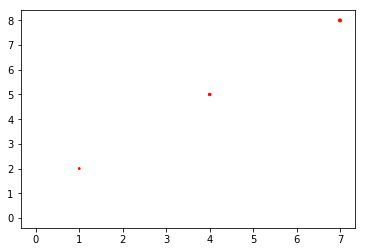

In [121]:
plt.scatter(coo[:,0], coo[:,1], coo[:,2], c="R")
plt.show()

In [111]:
coo[:,2]

array([0, 3, 6, 9])

In [112]:
plt.show()

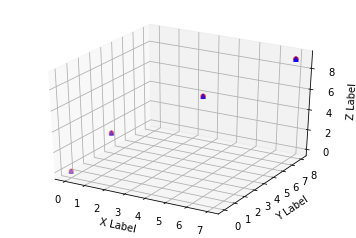

In [123]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np

# Fixing random state for reproducibility
np.random.seed(19680801)


def randrange(n, vmin, vmax):
    '''
    Helper function to make an array of random numbers having shape (n, )
    with each number distributed Uniform(vmin, vmax).
    '''
    return (vmax - vmin)*np.random.rand(n) + vmin

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

n = 100

# For each set of style and range settings, plot n random points in the box
# defined by x in [23, 32], y in [0, 100], z in [zlow, zhigh].
for c, m, zlow, zhigh in [('r', 'o', -50, -25), ('b', '^', -30, -5)]:
    xs = coo[:,0]
    ys = coo[:,1]
    zs = coo[:,2]
    ax.scatter(xs, ys, zs, c=c, marker=m)

ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

plt.show()